In [5]:
# Load config
from config import UNetTraining
# from config import UNetTraining
config = UNetTraining.Configuration()

In [6]:
from config import colors
colors = colors.bcolors()

# 0. Imports

In [125]:
import tensorflow as tf
import numpy as np
from PIL import Image
import rasterio
from rasterio.windows import Window

# import imgaug as ia
# from imgaug import augmenters as iaa
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import imageio
import os
import time
import rasterio.warp             # Reproject raster samples
from functools import reduce
from tensorflow.keras.models import load_model

from core.UNet import UNet
from core.losses import tversky, accuracy, dice_coef, dice_loss, specificity, sensitivity
from core.optimizers import adaDelta, adagrad, adam, nadam
from core.frame_info import FrameInfo
# from core.dataset_generator import DataGenerator
from core.split_frames import split_dataset
from core.visualize import display_images

import json
from sklearn.model_selection import train_test_split

%matplotlib inline
import matplotlib.pyplot as plt  # plotting tools
import matplotlib.patches as patches
from matplotlib.patches import Polygon

import warnings                  # ignore annoying warnings
warnings.filterwarnings("ignore")
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

%reload_ext autoreload
%autoreload 2
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [8]:
from sys import platform

if platform == "linux" or platform == "linux2":
    path_satellite = "/home/jovyan/work/satellite_data/"
    path_labels = os.getcwd() + "/1_labeled_data/tif/"
    cutouts_path = os.getcwd() + "/2_cutouts/"
elif platform == "darwin":
    path_data = "/Users/leori/Desktop/BA/1_Data/"
    path_satellite = path_data + "2_satellite/"
    path_labels = path_data + "1_labeled_data/tif/"
    cutouts_path = None
elif platform == "win32":
    print("Something went wrong")

# 1. Training

### Get Label Area

In [109]:
# get polygon coordinates 
import json
g = json.loads(labels_bounding_boxes.to_json())
coords = []
for polygon in range(len(g)):
    coords.append(g['features'][polygon]['geometry']['coordinates'][0])

In [110]:
coords[0]

[[29.995271839179495, -26.501297921923136],
 [29.995271839179495, -26.495656803219298],
 [30.001920300509017, -26.495656803219298],
 [30.001920300509017, -26.501297921923136],
 [29.995271839179495, -26.501297921923136]]

In [127]:
type(cutout_label)

numpy.ndarray

TypeError: _append_dispatcher() missing 1 required positional argument: 'values'

0 : 29.995271839179495 -26.501297921923136 30.001920300509017 -26.495656803219298


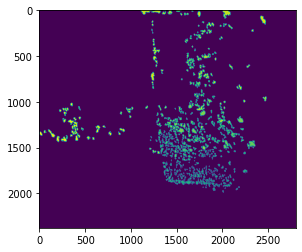

<AxesSubplot:>

1 : 29.748165906702567 -26.263430007776233 29.76650030217796 -26.248664051688667


In [167]:
from rasterio.windows import from_bounds
from rasterio.plot import show
# visualize labels
src_label = rasterio.open(config.filepath_label)
labels = []
for polygon in range(len(g)):
    west, south = coords[polygon][0][0], coords[polygon][0][1]
    east, north = coords[polygon][2][0], coords[polygon][2][1]
    print(polygon, ":", west, south, east, north)
    labels.append(src_label.read(1, window = from_bounds(west, south, east, north, src_label.transform)))
    show(labels[polygon])

### Patchify

In [ ]:
# get shapefile width & height. Else try coordinates
start_x, start_y, steps_x, steps_y

In [ ]:
%%time
window = Window(start_x, start_y, steps_x, steps_y)
patches_satellite = patchify(satellite_img.read([1,2,3], window=window), 
    (config.patch_size[0], config.patch_size[1], 3), 
    step=config.patch_size[0]-config.overlap)
# save patches
print("Patch Shape:", patches_satellite.shape)
# for i in range(4): # patches.shape[0]
#     for j in range(4): # patches.shape[1]
#         satellite_cutouts.append(patches[i,j])
# 
# img = cv2.imread("test.jpg")


for i in range(patches_satellite.shape[0]):
    for j in range(patches_satellite.shape[1]):
        single_patch = patches_satellite[i, j, 0, :, :, :]
        satellite_cutouts.append(single_patch)
        if not cv2.imwrite('patches/images/' + 'image_' + '_'+ str(i)+str(j)+'.jpg', single_patch):
            raise Exception("Could not write the image")


In [ ]:
if 0:
    for img in range(satellite_img.shape[0]):
        row = satellite_img[img]
        patches = patchify(row, (config.patch_size[0], config.patch_size[1], 1), step=config.patch_size[0]-config.overlap)
        # save patches
        print("Patch Shape:", patches.shape)
        for i in range(4): # patches.shape[0]
            for j in range(4): # patches.shape[1]
                satellite_cutouts.append(patches[i,j])

In [113]:
%%time
# cutout_satellite = src_satellite.read()
print(cutout_satellite.shape)

(3, 255, 256)
CPU times: user 139 µs, sys: 53 µs, total: 192 µs
Wall time: 154 µs


In [175]:
%%time
# cutout_label = src_label.read(1)
print(cutout_label.shape)

In [11]:
# print("Satellite Shape:", satellite_img.shape)
# print(satellite_img.width)
# print(satellite_img.height)
# # print("Label Shape:", label_img.shape)
# print(satellite_img.name)
# print(satellite_img.count)
# print("Indexes:", satellite_img.indexes)

### Create Cutouts with Steps

#### Data Generation

In [ ]:
training_frames, validation_frames, testing_frames  = split_dataset(frames, config.frames_json, config.patch_dir)
# training_frames = validation_frames = testing_frames  = list(range(len(frames)))

annotation_channels = config.input_label_channel + config.input_weight_channel
# DataGenerator performs Data Augmentation: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
train_generator = DataGenerator(config.input_image_channel, config.patch_size, training_frames, frames, annotation_channels, augmenter = 'iaa').random_generator(config.BATCH_SIZE, normalize = config.normalize)
val_generator = DataGenerator(config.input_image_channel, config.patch_size, validation_frames, frames, annotation_channels, augmenter= None).random_generator(config.BATCH_SIZE, normalize = config.normalize)
test_generator = DataGenerator(config.input_image_channel, config.patch_size, testing_frames, frames, annotation_channels, augmenter= None).random_generator(config.BATCH_SIZE, normalize = config.normalize)

In [ ]:
for _ in range(1):
    train_images, real_label = next(train_generator)
    ann = real_label[:,:,:,0]
    wei = real_label[:,:,:,1]
    #overlay of annotation with boundary to check the accuracy
    #5 images in each row are: pan, ndvi, annotation, weight(boundary), overlay of annotation with weight
    overlay = ann + wei
    overlay = overlay[:,:,:,np.newaxis]
    display_images(np.concatenate((train_images,real_label, overlay), axis = -1))

#### Compile Model

In [ ]:
OPTIMIZER = adaDelta
LOSS = tversky 

#Only for the name of the model in the very end
OPTIMIZER_NAME = 'AdaDelta'
LOSS_NAME = 'weightmap_tversky'

# Declare the path to the final model
# If you want to retrain an exising model then change the cell where model is declared. 
# This path is for storing a model after training.

timestr = time.strftime("%Y%m%d-%H%M")
chf = config.input_image_channel + config.input_label_channel
chs = reduce(lambda a,b: a+str(b), chf, '')


if not os.path.exists(config.model_path):
    os.makedirs(config.model_path)
model_path = os.path.join(config.model_path,'trees_{}_{}_{}_{}_{}.h5'.format(timestr,OPTIMIZER_NAME,LOSS_NAME,chs,config.input_shape[0]))

# The weights without the model architecture can also be saved. Just saving the weights is more efficent.

# weight_path="./saved_weights/UNet/{}/".format(timestr)
# if not os.path.exists(weight_path):
#     os.makedirs(weight_path)
# weight_path=weight_path + "{}_weights.best.hdf5".format('UNet_model')
# print(weight_path)

In [ ]:
# Define the model and compile it
model = UNet([config.BATCH_SIZE, *config.input_shape],config.input_label_channel)
model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=[dice_coef, dice_loss, specificity, sensitivity, accuracy])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        Input[0][0]                      
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 64) 256         conv2d_1[0][0]                   
______________________________________________________________________________________________

In [ ]:
# UNet([config.BATCH_SIZE, *config.input_shape],config.input_label_channel)

In [ ]:
# Define callbacks for the early stopping of training, LearningRateScheduler and model checkpointing
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard


checkpoint = ModelCheckpoint(model_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = False)

#reduceonplatea; It can be useful when using adam as optimizer
#Reduce learning rate when a metric has stopped improving (after some patience,reduce by a factor of 0.33, new_lr = lr * factor).
#cooldown: number of epochs to wait before resuming normal operation after lr has been reduced.
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.33,
                                   patience=4, verbose=1, mode='min',
                                   min_delta=0.0001, cooldown=4, min_lr=1e-16)

#early = EarlyStopping(monitor="val_loss", mode="min", verbose=2, patience=15)

log_dir = os.path.join('./logs','UNet_{}_{}_{}_{}_{}'.format(timestr,OPTIMIZER_NAME,LOSS_NAME,chs, config.input_shape[0]))
tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=0, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None, update_freq='epoch')

callbacks_list = [checkpoint, tensorboard] #reduceLROnPlat is not required with adaDelta

In [ ]:
def reset_cutouts():
    satellite_cutouts = satellite_cutouts = []
    print("Cutouts lists deleted.")
reset_cutouts()

Cutouts lists deleted.


In [ ]:
loss_history = [model.fit(satellite_cutouts, # array of img with shape of [(None, 512, 512, 4)] # train_generator
                         steps_per_epoch=config.MAX_TRAIN_STEPS, 
                         epochs=config.NB_EPOCHS, 
                         validation_data=satellite_cutouts,
                         validation_steps=config.VALID_IMG_COUNT,
                         callbacks=callbacks_list,
                         workers=1,
#                         use_multiprocessing=True # the generator is not very thread safe
                        )]

Epoch 1/200


ValueError: in user code:

    /Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:855 train_function  *
        return step_function(self, iterator)
    /Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:845 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:1285 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2833 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3608 _call_for_each_replica
        return fn(*args, **kwargs)
    /Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:838 run_step  **
        outputs = model.train_step(data)
    /Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:795 train_step
        y_pred = self(x, training=True)
    /Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer.py:1013 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/tensorflow/python/keras/engine/input_spec.py:200 assert_input_compatibility
        raise ValueError('Layer ' + layer_name + ' expects ' +

    ValueError: Layer model_1 expects 1 input(s), but it received 15 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(1, 512) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1' shape=(1, 511) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2' shape=(1, 512) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3' shape=(1, 512) dtype=uint8>, <tf.Tensor 'IteratorGetNext:4' shape=(1, 511) dtype=uint8>, <tf.Tensor 'IteratorGetNext:5' shape=(1, 512) dtype=uint8>, <tf.Tensor 'IteratorGetNext:6' shape=(1, 511) dtype=uint8>, <tf.Tensor 'IteratorGetNext:7' shape=(1, 512) dtype=uint8>, <tf.Tensor 'IteratorGetNext:8' shape=(1, 512) dtype=uint8>, <tf.Tensor 'IteratorGetNext:9' shape=(1, 511) dtype=uint8>, <tf.Tensor 'IteratorGetNext:10' shape=(1, 512) dtype=uint8>, <tf.Tensor 'IteratorGetNext:11' shape=(1, 511) dtype=uint8>, <tf.Tensor 'IteratorGetNext:12' shape=(1, 512) dtype=uint8>, <tf.Tensor 'IteratorGetNext:13' shape=(1, 512) dtype=uint8>, <tf.Tensor 'IteratorGetNext:14' shape=(1, 511) dtype=uint8>]


In [9]:
import numpy as np
from matplotlib import pyplot as plt
from patchify import patchify

satellite_img = rasterio.open(config.filepath_satellite)
label_img = rasterio.open(config.filepath_label)

In [12]:
%%time
start_x = start_y = 0
# load the west half of the satellite image
steps_x = satellite_img.shape[1] / 2
steps_y = satellite_img.shape[0] # / 2
window = Window(start_x, start_y, steps_x, steps_y)
read_sat_west_half = satellite_img.read([1,2,3], window=window)
read_sat_west_half.shape

CPU times: user 18.1 s, sys: 28.2 s, total: 46.4 s
Wall time: 53.6 s


(3, 107798, 54112)

In [14]:
%%time
# load the east half of the satellite image
start_x = steps_x
steps_x = satellite_img.shape[1] - steps_x # if size in px is uneven
window = Window(start_x, start_y, steps_x, steps_y)
read_sat_east_half = satellite_img.read([1,2,3], window=window)
read_sat_east_half.shape

CPU times: user 19.1 s, sys: 32.4 s, total: 51.5 s
Wall time: 1min 8s


(3, 107798, 54112)

In [19]:
# Concat numpy patches array
# read_sat = np.concatenate((read_sat_west_half, read_sat_east_half))

In [18]:
read_sat_west_half.shape, read_sat_east_half.shape

((3, 107798, 54112), (3, 107798, 54112))

# 2. Evaluation

In [5]:
# change so that it uses 512 px img instead of 256
from tensorflow.keras import models, layers
from tensorflow.keras import regularizers

def UNet(input_shape, input_label_channel, layer_count=64, regularizers = regularizers.l2(0.0001), gaussian_noise=0.1, weight_file = None):
        """ Method to declare the UNet model.

        Args:
            input_shape: tuple(int, int, int, int)
                Shape of the input in the format (batch, height, width, channels).
            input_label_channel: list([int])
                list of index of label channels, used for calculating the number of channels in model output.
            layer_count: (int, optional)
                Count of kernels in first layer. Number of kernels in other layers grows with a fixed factor.
            regularizers: keras.regularizers
                regularizers to use in each layer.
            weight_file: str
                path to the weight file.
        """

        input_img = layers.Input(input_shape[1:], name='Input')
        pp_in_layer  = input_img
#        pp_in_layer = layers.GaussianNoise(gaussian_noise)(input_img)
#        pp_in_layer = layers.BatchNormalization()(pp_in_layer)


        c1 = layers.Conv2D(1*layer_count, (3, 3), activation='relu', padding='same')(pp_in_layer)
        c1 = layers.Conv2D(1*layer_count, (3, 3), activation='relu', padding='same')(c1)
        n1 = layers.BatchNormalization()(c1)
        p1 = layers.MaxPooling2D((2, 2))(n1)

        c2 = layers.Conv2D(2*layer_count, (3, 3), activation='relu', padding='same')(p1)
        c2 = layers.Conv2D(2*layer_count, (3, 3), activation='relu', padding='same')(c2)
        n2 = layers.BatchNormalization()(c2)
        p2 = layers.MaxPooling2D((2, 2))(n2)

        c3 = layers.Conv2D(4*layer_count, (3, 3), activation='relu', padding='same')(p2)
        c3 = layers.Conv2D(4*layer_count, (3, 3), activation='relu', padding='same')(c3)
        n3 = layers.BatchNormalization()(c3)
        p3 = layers.MaxPooling2D((2, 2))(n3)

        c4 = layers.Conv2D(8*layer_count, (3, 3), activation='relu', padding='same')(p3)
        c4 = layers.Conv2D(8*layer_count, (3, 3), activation='relu', padding='same')(c4)
        n4 = layers.BatchNormalization()(c4)
        p4 = layers.MaxPooling2D(pool_size=(2, 2))(n4)

        c5 = layers.Conv2D(16*layer_count, (3, 3), activation='relu', padding='same')(p4)
        c5 = layers.Conv2D(16*layer_count, (3, 3), activation='relu', padding='same')(c5)

        u6 = layers.UpSampling2D((2, 2))(c5)
        n6 = layers.BatchNormalization()(u6)
        u6 = layers.concatenate([n6, n4])
        c6 = layers.Conv2D(8*layer_count, (3, 3), activation='relu', padding='same')(u6)
        c6 = layers.Conv2D(8*layer_count, (3, 3), activation='relu', padding='same')(c6)

        u7 = layers.UpSampling2D((2, 2))(c6)
        n7 = layers.BatchNormalization()(u7)
        u7 = layers.concatenate([n7, n3])
        c7 = layers.Conv2D(4*layer_count, (3, 3), activation='relu', padding='same')(u7)
        c7 = layers.Conv2D(4*layer_count, (3, 3), activation='relu', padding='same')(c7)

        u8 = layers.UpSampling2D((2, 2))(c7)
        n8 = layers.BatchNormalization()(u8)
        u8 = layers.concatenate([n8, n2])
        c8 = layers.Conv2D(2*layer_count, (3, 3), activation='relu', padding='same')(u8)
        c8 = layers.Conv2D(2*layer_count, (3, 3), activation='relu', padding='same')(c8)

        u9 = layers.UpSampling2D((2, 2))(c8)
        n9 = layers.BatchNormalization()(u9)
        u9 = layers.concatenate([n9, n1], axis=3)
        c9 = layers.Conv2D(1*layer_count, (3, 3), activation='relu', padding='same')(u9)
        c9 = layers.Conv2D(1*layer_count, (3, 3), activation='relu', padding='same')(c9)

        d = layers.Conv2D(len(input_label_channel), (1, 1), activation='sigmoid', kernel_regularizer= regularizers)(c9)

        seg_model = models.Model(inputs=[input_img], outputs=[d])
        if weight_file:
            seg_model.load_weights(weight_file)
        seg_model.summary()
        return seg_model

# 3. Prediction

# 9. YT Video: Preview of Test Prediction

In [ ]:
#Load previously saved model
from keras.models import load_model
# model = load_model("/content/drive/MyDrive/Colab Notebooks/saved_models/tutorial118_mitochondria_25epochs.hdf5", compile=False)

In [ ]:
#IOU
y_pred=model.predict(X_test)
# if model is more than 50% sure it is a cell, it returns True, else False
y_pred_thresholded = y_pred > 0.5 

In [ ]:
from tensorflow.keras.metrics import MeanIoU
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_pred_thresholded, y_test)
print("Mean IoU =", IOU_keras.result().numpy())

In [ ]:
threshold = 0.5
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
print(test_img_input.shape)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
print(prediction.shape)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()